In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import torch
import itertools

In [2]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

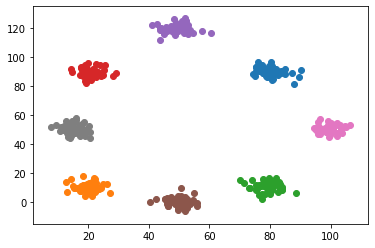

In [3]:
n_samps = 50

means = np.array([[8,9], [2,1], [8,1], [2,9], [5,12], [5,0], [10, 5], [1.5,5]]) * 10
data = np.zeros((len(means)*n_samps,2))
y = np.zeros((len(means)*n_samps,1))
for ind, m in enumerate(means):
    samps = multivariate_normal(m, np.eye(2)/0.1).rvs(n_samps)#.astype(int)
    data[ind*n_samps:((ind+1)*n_samps)] = samps
    y[ind*n_samps:((ind+1)*n_samps)] = np.tile(ind, n_samps).reshape(-1,1)
    plt.scatter(samps[:,0], samps[:,1])


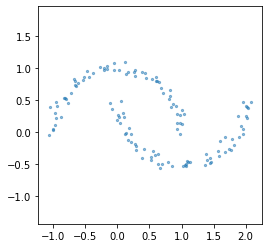

In [4]:
# Lightweight datasets
import pickle
from sklearn import datasets

class DatasetSIGGRAPH:
    """ 
    haha, found from Eric https://blog.evjang.com/2018/01/nf2.html
    https://github.com/ericjang/normalizing-flows-tutorial/blob/master/siggraph.pkl
    """
    def __init__(self):
        with open('siggraph.pkl', 'rb') as f:
            XY = np.array(pickle.load(f), dtype=np.float32)
            XY -= np.mean(XY, axis=0) # center
        self.XY = torch.from_numpy(XY)
    
    def sample(self, n):
        X = self.XY[np.random.randint(self.XY.shape[0], size=n)]
        return X

class DatasetMoons:
    """ two half-moons """
    def sample(self, n):
        moons = datasets.make_moons(n_samples=n, noise=0.05)[0].astype(np.float32)
        return torch.from_numpy(moons)

class DatasetMixture:
    """ 4 mixture of gaussians """
    def sample(self, n):
        assert n%4 == 0
        r = np.r_[np.random.randn(n // 4, 2)*0.5 + np.array([0, -2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([0, 0]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([2, 2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([-2, 2])]
        return torch.from_numpy(r.astype(np.float32))

def eightMixture_sample(batch_size):
    rand = np.random.choice(np.arange(len(data)), batch_size)
    return data[rand,:]

def oh_eightMixture_sample(batch_size):
    rand = np.random.choice(np.arange(len(oh)), batch_size)
    return oh[rand,:]
    
d = DatasetMoons()
#d = DatasetMixture()
#d = DatasetSIGGRAPH()

x = d.sample(128)
plt.figure(figsize=(4,4))
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
plt.axis('equal');

In [5]:
def torch_oh(input, vocab_size, axis=-1):
    input = input-input.min()
    x = input.flatten().unsqueeze(1).long()
    z = torch.zeros((input.shape[0]*input.shape[1], vocab_size ))
    z.scatter_(1,x,1)
    z = z.view(input.shape[0], input.shape[1], vocab_size)
    return z

torch.Size([64, 2])


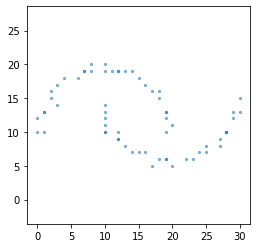

In [6]:
import os
os.chdir('../pytorch')

import nflib.disc_utils
ds_moons = DatasetMoons()
moons_vocab_size = 35
# need to make one hot. 
def int_moons_sample(batch_size):
    x = ds_moons.sample(batch_size)*10
    x = x.type(torch.int)
    x = torch_oh(x, moons_vocab_size, axis=-1)
    return x

x = int_moons_sample(64).argmax(-1)
print(x.shape)
plt.figure(figsize=(4,4))
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
plt.axis('equal');

In [7]:
print(x.max(), x.min())

tensor(30) tensor(0)


In [8]:
data.shape

(400, 2)

In [9]:
batch_size, sequence_length, vocab_size = 32,  2, 150

def one_hotter(x, depth):
    idd = np.eye(depth)
    #print(idd[0])
    res = np.zeros((x.shape[0], x.shape[1], depth))
    #print(res.shape)
    for ind in range(len(x)): 
        for j, val in enumerate(x[ind]):
            res[ind, j, :] = idd[int(val)]
            
    return res
            

oh = one_hotter(data, vocab_size)

In [51]:
from nflib.MADE import *
from nflib.flows import *
from nflib.spline_flows import NSF_AR, NSF_CL

base = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(2), torch.eye(2))

# RealNVP
#flows = [AffineHalfFlow(dim=2, parity=i%2) for i in range(9)]

# NICE
flows = [AffineHalfFlow(dim=2, parity=i%2, scale=False, block_mask=False) for i in range(4)]
flows.append(AffineConstantFlow(dim=2, shift=False))

# SlowMAF (MAF, but without any parameter sharing for each dimension's scale/shift)
# flows = [SlowMAF(dim=2, parity=i%2) for i in range(4)]

# MAF (with MADE net, so we get very fast density estimation)
#flows = [MAF(dim=2, parity=i%2) for i in range(4)]

# Neural splines, coupling
'''nfs_flow = NSF_CL if True else NSF_AR
flows = [nfs_flow(dim=2, K=8, B=3, hidden_dim=16) for _ in range(3)]
convs = [Invertible1x1Conv(dim=2) for _ in flows]
norms = [ActNorm(dim=2) for _ in flows]
flows = list(itertools.chain(*zip(norms, convs, flows)))
'''

model = NormalizingFlowModel(base, flows)

In [52]:
torch.rand(5,10).sum(-1)

tensor([3.7813, 4.2067, 5.4033, 6.6964, 3.9817])

In [53]:
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  5094


In [54]:
base.sample((100,));

In [55]:
type(torch.Tensor(data[:batch_size,:]))

torch.Tensor

forward is from data to latent. backward is from latent to data

0 2660985.0
100 122012.6328125
200 61476.46484375
300 40529.73046875
400 30323.171875
500 25267.939453125
600 18124.59765625
700 14241.9033203125
800 11044.2646484375
900 10444.6025390625
1000 9016.669921875
1100 7818.0244140625
1200 6832.6162109375
1300 6774.3837890625
1400 5963.68212890625
1500 6623.1953125
1600 4771.32958984375
1700 5282.74560546875
1800 4552.6064453125
1900 4929.6025390625
2000 3992.376708984375
2100 3808.025634765625
2200 3845.18212890625
2300 4271.46044921875
2400 3736.390625
2500 3215.2119140625
2600 3251.865234375
2700 3133.49658203125
2800 2986.70703125
2900 2876.07177734375
3000 3168.420654296875
3100 3088.007568359375
3200 2767.972900390625
3300 3719.944580078125
3400 2875.952392578125
3500 2692.38134765625
3600 2629.283203125
3700 2851.73583984375
3800 2595.0126953125
3900 2521.689453125
4000 2491.010009765625
4100 2882.16455078125
4200 2436.48095703125
4300 2523.404541015625
4400 2415.201171875
4500 2878.54931640625
4600 2444.697509765625
4700 2604.1384277

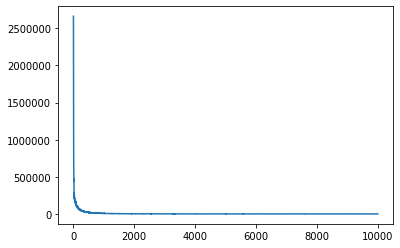

In [56]:
epochs = 10000
batch_size = 248
learning_rate=0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []

#x = torch.Tensor(data[:batch_size,:])

model.train()
for e in range(epochs): 
    
    #x = d.sample(batch_size)
    x = torch.Tensor(eightMixture_sample(batch_size))
    
    optimizer.zero_grad()
    
    zs, prior_logprob, log_det = model.forward( x )
    # get the back output after every transformation currently!
    #print(back_probs)
    logprob = prior_logprob + log_det
    loss = -torch.sum(logprob)
    #print(loss)
    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.detach())
    
    if e%100==0:
        print(e, loss.item())
    
    
plt.plot(losses)
    

Text(0.5, 1.0, 'z -> x')

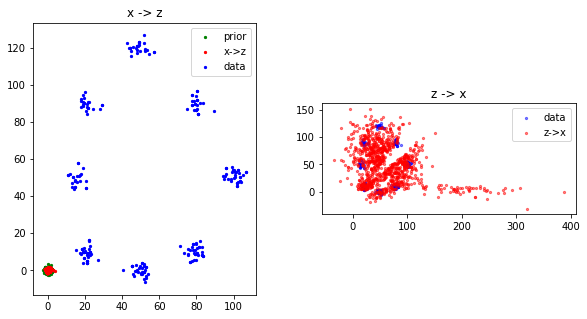

In [58]:
model.eval()

#x = d.sample(128)
x = torch.Tensor(eightMixture_sample(batch_size))
zs, prior_logprob, log_det = model(x)
z = zs

x = x.detach().numpy()
z = z.detach().numpy()
p = model.prior.sample([128, 2]).squeeze()
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(z[:,0], z[:,1], c='r', s=5)
plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.legend(['prior', 'x->z', 'data'])
plt.axis('scaled')
plt.title('x -> z')

zs = model.sample(128*8)
z = zs
z = z.detach().numpy()
plt.subplot(122)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.legend(['data', 'z->x'])
plt.axis('scaled')
plt.title('z -> x')

In [26]:
def plot2D(x):
    plt.scatter(x[:,0], x[:,1])
    plt.show()

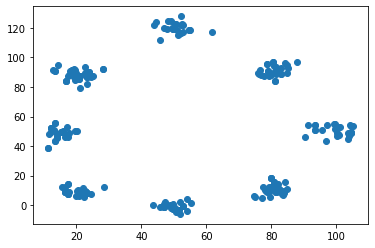

In [27]:
x = eightMixture_sample(batch_size)
plot2D(x)

In [59]:
model.eval()

samps = model.sample(batch_size)
samps = samps.detach().numpy()
plot2D(samps)

NameError: name 'plot2D' is not defined

In [ ]:
samps;

# Discrete Flows

In [219]:
os.chdir('nflib')

FileNotFoundError: [Errno 2] No such file or directory: 'nflib'

In [307]:

from TorchDiscCode import *

In [312]:
num_flows = 6
nh = 64
batch_size= 1024
sequence_length = 2
vocab_size = 35
vector_length = sequence_length*vocab_size
temperature = 0.1
flows = []
disc_layer_type =  'bipartite' # 'autoreg'

In [313]:
np.arange(10)[1::2]

array([1, 3, 5, 7, 9])

In [314]:
for i in range(num_flows):
    # if want to also learn the scale: 
    # MADE(vocab_size, [nh, nh, nh], 2*vocab_size, num_masks=1, natural_ordering=False)
    if disc_layer_type == 'autoreg':
        layer = MADE(vocab_size, [nh, nh, nh], vocab_size, 
                     num_masks=1, natural_ordering=False)
        disc_layer = DiscreteAutoregressiveFlow( layer, temperature, vocab_size )
    
    
    elif disc_layer_type == 'bipartite':
        layer = MLP(vector_length//2, vector_length//2, nh) # vector_length//2 = vocab_size
        
        # random masking
        '''mask = np.zeros(vector_length)
        mask[:vector_length//2]= 1
        np.random.shuffle(mask)'''
        
        '''# parity flipping
        mask = np.zeros((batch_size, vector_length))
        if i%2==0:
            #mask[:, np.arange(vector_length)[::2] ] = 1.0
            mask[:, :vector_length//2]=1.0
        else:
            #mask[:, np.arange(vector_length)[1::2] ] = 1.0
            mask[:, vector_length//2:]=1.0
            
        mask = mask.reshape(-1, sequence_length, vocab_size)
        print(mask.shape)'''
        
        disc_layer = DiscreteBipartiteFlow(layer, i%2, temperature, vocab_size, vector_length)
    flows.append(disc_layer)
    
model = DiscreteAutoFlowModel(flows)
    

In [315]:
rand_source = torch.distributions.normal.Normal(0,1)
rand_samps = rand_source.sample([sequence_length, vocab_size])

rand_samps.shape

torch.Size([2, 35])

In [316]:
rand_samps

tensor([[ 5.4693e-01,  1.0037e-02, -7.7358e-01,  6.3286e-01,  1.9432e+00,
          4.1794e-01, -3.8738e-02,  1.7005e-01,  5.3787e-01, -1.1117e-01,
         -4.3334e-01,  7.7608e-01,  5.6857e-01,  5.5077e-01, -8.7747e-01,
          3.7983e-01,  8.5850e-01,  1.9630e+00, -1.0622e+00, -1.6716e-01,
          5.0055e-01, -1.8316e+00, -8.0483e-01, -1.0035e+00, -3.7487e-01,
         -8.6262e-02, -6.0800e-01, -1.9699e+00,  2.0148e-01,  8.2848e-03,
         -1.6394e+00,  8.0248e-01,  3.6407e-01, -8.9199e-01, -1.0387e+00],
        [ 4.9044e-04, -8.4391e-01,  1.6928e-01, -3.6849e-01, -2.1676e+00,
          7.7261e-01,  5.2252e-01,  7.0085e-01,  1.5428e+00, -1.0584e-01,
         -1.3108e+00,  3.5438e-01,  6.0290e-01, -1.0918e+00,  3.3902e-01,
         -1.3803e-01,  5.2181e-01,  8.2004e-02,  2.2708e+00,  2.2829e+00,
         -9.6166e-01, -2.5102e+00,  5.7343e-01,  6.2736e-01, -1.4929e+00,
          1.3834e+00, -2.2851e+00,  9.1119e-01,  1.0578e+00,  7.0365e-01,
         -5.0629e-02,  1.1348e+00, -3

In [326]:
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform 

rand_source = TransformedDistribution(Uniform(torch.zeros(1), torch.ones(1)), SigmoidTransform().inv)
rand_samps = rand_source.sample([sequence_length, vocab_size]).squeeze()
rand_samps.shape

torch.Size([2, 35])

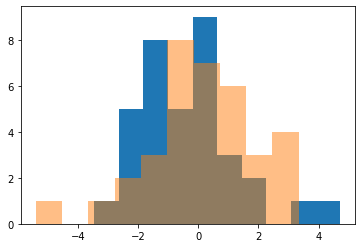

In [327]:
plt.hist(rand_samps[0,:])
plt.hist(rand_samps[1,:], alpha=0.5)
plt.show()

(array([109.,  85.,  21.,  15.,  35.,  50., 110., 212., 337.,  50.]),
 array([ 0. ,  3.4,  6.8, 10.2, 13.6, 17. , 20.4, 23.8, 27.2, 30.6, 34. ]),
 <a list of 10 Patch objects>)

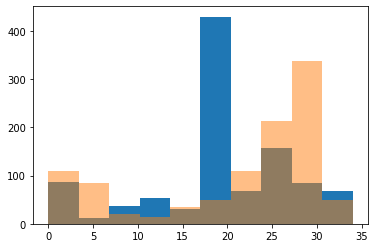

In [319]:
base = torch.distributions.OneHotCategorical(logits = rand_samps )
samps = base.sample((batch_size,)).argmax(-1)
plt.hist(samps[:,0])
plt.hist(samps[:,1], alpha=0.5)

(array([ 3.,  2.,  4., 14., 22., 22., 20.,  6.,  4.,  3.]),
 array([15.12021341, 15.71636379, 16.31251418, 16.90866456, 17.50481495,
        18.10096533, 18.69711572, 19.2932661 , 19.88941649, 20.48556687,
        21.08171726]),
 <a list of 10 Patch objects>)

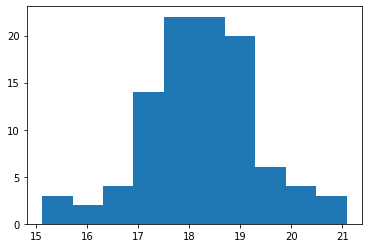

In [325]:
plt.hist(np.random.normal(18,1,100))

(array([ 71., 215.,  30.,  23.,  27., 231.,  18.,  89., 170., 150.]),
 array([ 0. ,  3.4,  6.8, 10.2, 13.6, 17. , 20.4, 23.8, 27.2, 30.6, 34. ]),
 <a list of 10 Patch objects>)

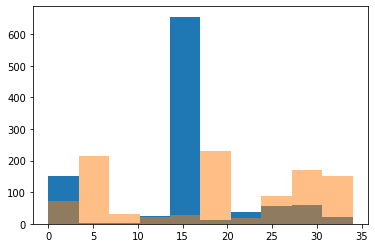

In [328]:
base = torch.distributions.OneHotCategorical(logits = rand_samps )
samps = base.sample((batch_size,)).argmax(-1)
plt.hist(samps[:,0])
plt.hist(samps[:,1], alpha=0.5)

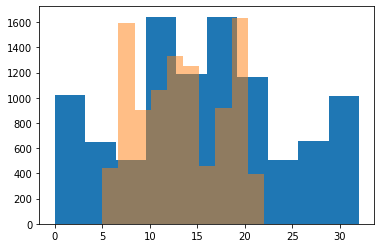

In [295]:
n_moon_samps = 10000
moon_samp = int_moons_sample(n_moon_samps).float().argmax(-1)
plt.hist(moon_samp[:,0])
#plt.show()
plt.hist(moon_samp[:,1], alpha=0.5)
plt.show()

In [296]:
import collections
import pandas as pd
moon_dim0 = collections.Counter(moon_samp[:,0].detach().numpy())
moon_dim1 = collections.Counter(moon_samp[:,1].detach().numpy())
dim0_probs = np.zeros((vocab_size))
dim1_probs = np.zeros((vocab_size))
for k, v in moon_dim0.items():
    dim0_probs[k] = v/n_moon_samps
for k, v in moon_dim1.items():
    dim1_probs[k] = (v/n_moon_samps)

dim0_probs += 0.000001
dim1_probs += 0.000001

# need to renormalize again... 


dim0_probs = dim0_probs / np.sum(dim0_probs)
dim1_probs = dim1_probs / np.sum(dim1_probs)

In [297]:
moon_probs = np.vstack([dim0_probs, dim1_probs])
'''moon_hist = moon_probs*1000
plt.hist(moon_hist[0,:])
#plt.show()
plt.hist(moon_hist[1,:], alpha=0.5)
plt.show()
'''

'moon_hist = moon_probs*1000\nplt.hist(moon_hist[0,:])\n#plt.show()\nplt.hist(moon_hist[1,:], alpha=0.5)\nplt.show()\n'

(array([ 426., 1594.,  900., 1041., 1309., 1270.,  453.,  947., 1665.,
         395.]),
 array([ 5. ,  6.7,  8.4, 10.1, 11.8, 13.5, 15.2, 16.9, 18.6, 20.3, 22. ]),
 <a list of 10 Patch objects>)

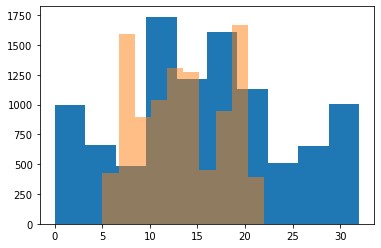

In [298]:
base = torch.distributions.OneHotCategorical(probs = torch.tensor(moon_probs).float() )
samps = base.sample((10000,)).argmax(-1)
plt.hist(samps[:,0])
plt.hist(samps[:,1], alpha=0.5)

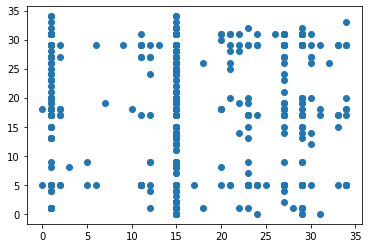

In [329]:
def plot2D(x):
    plt.scatter(x[:,0], x[:,1])
    plt.show()
    
plot2D(samps)

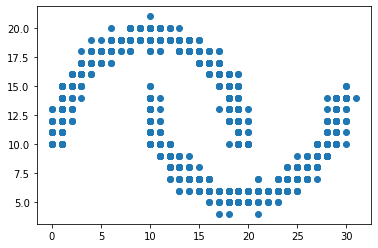

In [330]:
x = int_moons_sample(batch_size)
plot2D(x.argmax(-1))


MLP(
  (net): Sequential(
    (0): Linear(in_features=35, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=64, out_features=35, bias=True)
  )
)
torch.Size([35, 64])


(array([ 6., 10.,  7.,  3.,  9.,  5.,  6.,  6.,  5.,  7.]),
 array([-0.12339473, -0.09893253, -0.07447033, -0.05000812, -0.02554592,
        -0.00108372,  0.02337849,  0.04784069,  0.07230289,  0.09676509,
         0.12122729], dtype=float32),
 <a list of 10 Patch objects>)

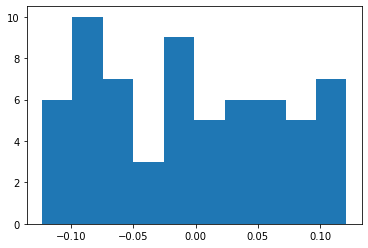

In [331]:
flow_num = 0
sub_part = 6
print(model.flows[flow_num]._modules['layer'])
w = model.flows[flow_num]._modules['layer'].net[sub_part]._parameters['weight'] 
print(w.shape)
plt.hist(w.detach().numpy()[0,:])

In [332]:
model.reverse(x)

AssertionError: need to flatten the inputs first!!!

In [333]:
zs[0]

tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]],
       grad_fn=<SelectBackward>)

In [334]:

disc_utils.one_hot_add(  torch.eye(10), torch.eye(10)  )

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

In [335]:
base.probs

tensor([[1.0986e-03, 1.3885e-01, 8.3745e-03, 1.4672e-03, 6.2204e-04, 4.1642e-03,
         4.2836e-03, 1.1373e-03, 1.2804e-03, 7.2577e-04, 4.9165e-03, 1.5076e-02,
         6.9598e-03, 1.7779e-03, 8.5612e-04, 6.1604e-01, 6.9793e-04, 5.7837e-04,
         1.7743e-03, 1.7275e-04, 1.0738e-02, 7.5464e-03, 3.7884e-03, 2.3260e-02,
         8.9361e-03, 5.6586e-03, 9.0883e-04, 4.7861e-02, 2.2155e-03, 5.0763e-02,
         9.3707e-03, 2.4027e-03, 1.1612e-03, 5.5370e-03, 9.0024e-03],
        [5.2825e-03, 5.5739e-02, 5.3950e-03, 1.6412e-03, 5.7201e-03, 2.0846e-01,
         3.3365e-05, 2.1338e-03, 1.4249e-02, 2.2595e-02, 9.6582e-04, 5.9474e-03,
         6.1299e-03, 1.8400e-02, 7.9897e-03, 2.6635e-02, 1.0063e-03, 1.0601e-01,
         5.0074e-02, 2.9452e-02, 3.2749e-02, 1.1104e-02, 4.2024e-03, 4.8029e-03,
         8.7401e-03, 1.1458e-02, 1.9837e-02, 4.6739e-02, 6.0420e-03, 1.4271e-01,
         3.3203e-04, 1.1583e-01, 1.2815e-02, 1.9959e-03, 6.7818e-03]])

0 9.136606216430664
5 8.718175888061523
10 9.2853422164917
15 9.326683044433594
20 8.687267303466797
25 9.372249603271484
30 9.27023983001709
35 8.7128324508667
40 8.690667152404785
45 8.580217361450195
50 8.67030143737793
55 8.665182113647461
60 8.706905364990234
65 8.752385139465332
70 9.256819725036621
75 9.291762351989746
80 8.700927734375
85 8.669492721557617
90 9.302939414978027
95 8.66256332397461
100 8.67143726348877
105 9.201868057250977
110 8.68649673461914
115 8.688070297241211
120 9.299087524414062
125 9.363716125488281
130 9.298653602600098
135 8.778862953186035
140 8.62126350402832
145 8.641079902648926
150 8.70256233215332
155 8.592439651489258
160 8.682104110717773
165 8.737081527709961
170 9.245282173156738
175 8.617317199707031
180 9.224071502685547
185 8.591644287109375
190 9.284653663635254
195 8.777328491210938
200 8.659525871276855
205 8.702688217163086
210 9.27034854888916
215 9.333819389343262
220 8.67823600769043
225 8.679521560668945
230 9.279619216918945
235 

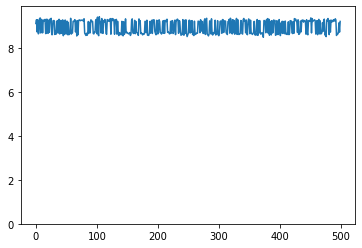

In [362]:
epochs = 500
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []
weights = []
#x = torch.Tensor(data[:batch_size,:])
base_log_probs = torch.log(base.probs)
model.train()
for e in range(epochs):
    
    #x = d.sample(batch_size)
    #x = torch.tensor(oh_eightMixture_sample(batch_size)).float()
    x = int_moons_sample(batch_size).float()
    if disc_layer_type == 'bipartite':
        x= x.view(x.shape[0], -1)
    
    optimizer.zero_grad()
    zs = model.reverse(x)
    
    if disc_layer_type == 'bipartite':
        zs = zs.view(batch_size, 2, -1)
    logprob = zs*base_log_probs.float()
    loss = -torch.sum(logprob)/batch_size
    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.detach())
    
    if e%5==0:
        print(e, loss.item())
        #plotting the weights of a single layer: 
        
        flow_num = num_flows-1
        sub_part = 6
        w = model.flows[flow_num]._modules['layer'].net[sub_part]._parameters['weight'].detach().numpy()
        #print(w.shape)
        weights.append(w)
        plt.hist(w[0,:],bins=100)
        plt.show()
    
plt.plot(losses)

In [338]:
ma_loss = [losses[0]]
ind = 1
for l in losses[1:]:
    ma_loss.append( ma_loss[ind-1] +0.01*(l-ma_loss[ind-1]) )
    ind+=1

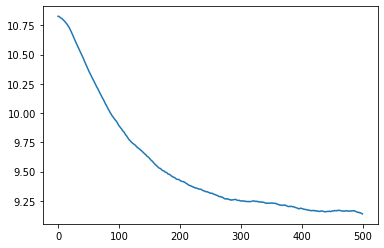

In [339]:
plt.plot(ma_loss)

(1024, 2)


(0, 35)

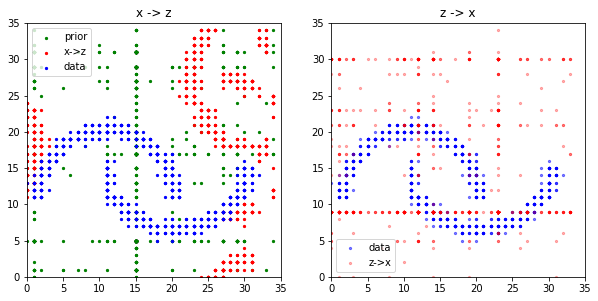

In [353]:
model.eval()

#x = d.sample(128)
x = int_moons_sample(batch_size).float()
if disc_layer_type == 'bipartite':
    x = x.view(batch_size, -1)
zs = model.reverse(x)
z = zs
if disc_layer_type == 'bipartite':
    z = z.view(batch_size, 2, -1)
    x = x.view(batch_size, 2, -1)

x = x.detach().numpy().argmax(-1)
z = z.detach().numpy().argmax(-1)
print(z.shape)
p = base.sample((batch_size,)).argmax(-1)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(z[:,0], z[:,1], c='r', s=5)
plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.legend(['prior', 'x->z', 'data'])
plt.axis('scaled')
plt.title('x -> z')
plt.xlim([0,vocab_size])
plt.ylim([0,vocab_size])

if disc_layer_type == 'bipartite':
    zs = model.forward(base.sample((batch_size,)).float().view(batch_size, -1))
else: 
    zs = model.forward(base.sample((batch_size,)).float())
z = zs
if disc_layer_type == 'bipartite':
    z = z.view(batch_size, 2, -1)
z = z.detach().numpy().argmax(-1)
plt.subplot(122)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.3)
plt.legend(['data', 'z->x'])
plt.axis('scaled')
plt.title('z -> x')
plt.xlim([0,vocab_size])
plt.ylim([0,vocab_size])

In [354]:
z.shape

(1024, 2)

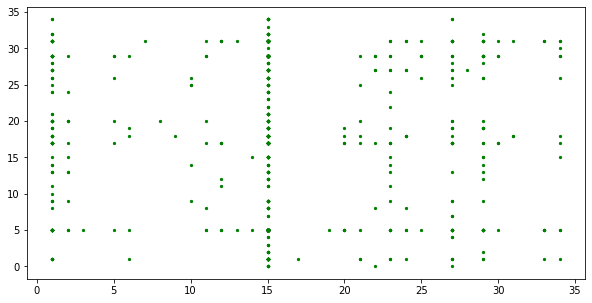

In [360]:
p = base.sample((batch_size,)).argmax(-1)
plt.figure(figsize=(10,5))

plt.scatter(p[:,0], p[:,1], c='g', s=5)

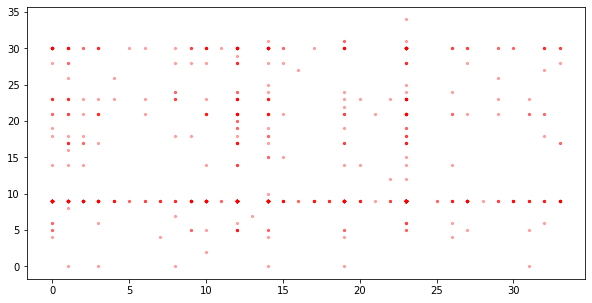

In [361]:
plt.figure(figsize=(10,5))
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.3)

In [347]:
base.logits

tensor([[ -6.8138,  -1.9744,  -4.7826,  -6.5244,  -7.3825,  -5.4812,  -5.4530,
          -6.7791,  -6.6606,  -7.2283,  -5.3152,  -4.1946,  -4.9676,  -6.3323,
          -7.0631,  -0.4844,  -7.2674,  -7.4553,  -6.3343,  -8.6637,  -4.5339,
          -4.8867,  -5.5758,  -3.7610,  -4.7177,  -5.1746,  -7.0034,  -3.0394,
          -6.1123,  -2.9806,  -4.6702,  -6.0312,  -6.7583,  -5.1963,  -4.7103],
        [ -5.2434,  -2.8871,  -5.2223,  -6.4123,  -5.1638,  -1.5680, -10.3080,
          -6.1499,  -4.2511,  -3.7900,  -6.9425,  -5.1248,  -5.0946,  -3.9954,
          -4.8296,  -3.6255,  -6.9015,  -2.2442,  -2.9943,  -3.5250,  -3.4189,
          -4.5004,  -5.4721,  -5.3385,  -4.7398,  -4.4691,  -3.9202,  -3.0632,
          -5.1090,  -1.9469,  -8.0103,  -2.1557,  -4.3572,  -6.2167,  -4.9935]])

In [348]:
'''

f.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(
                labels=model.reverse(dataset[:batch_size,:,:]), # data into latent. 
              logits=model_rv.distribution.base.logits)) # i think these are the probabilitis of the 
              # latent transformed into the data. 

'''

'\n\nf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(\n                labels=model.reverse(dataset[:batch_size,:,:]), # data into latent. \n              logits=model_rv.distribution.base.logits)) # i think these are the probabilitis of the \n              # latent transformed into the data. \n\n'

# Model learns how to map the data up to the categories well! When there are 4 layers of MADE.

In [349]:
# making sure that the forward and reverse are in fact still invertible with each other. 

x = int_moons_sample(batch_size).float()
zs = model.reverse(x)
x_hats = model.forward(zs)

x = x.detach().numpy().argmax(-1)
z = zs.detach().numpy().argmax(-1)
x_hats = x_hats.detach().numpy().argmax(-1)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(z[:,0], z[:,1], c='r', s=5)
plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.scatter(x_hats[:,0], x_hats[:,1], c='g', s=5) # this is the replication

AssertionError: need to flatten the inputs first!!!

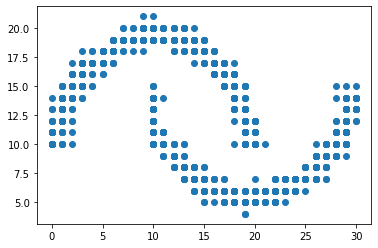

In [350]:
x = int_moons_sample(batch_size)
plot2D(x.argmax(-1))

torch.Size([1024, 2])


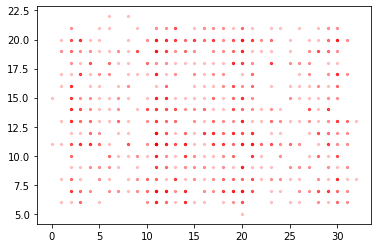

In [270]:
# smaller sample to see what happens
if disc_layer_type == 'bipartite':
    a = model.forward(base.sample((1024,)).float().view(batch_size,-1)).view(batch_size, 2, -1).argmax(-1)
else:
    a = model.forward(base.sample((1024,)).float()).argmax(-1)

print(a.shape)
plt.scatter(a[:,0], a[:,1], c='r', s=5,alpha=0.2)

# Looking at the probabilities assigned to each transformed point

In [271]:
# weight each of the points by the probability that they are appearing!
samps = base.sample((batch_size,)).float()
samps_probs = torch.exp( (torch.log(base.probs) * samps).sum(-1).sum(-1) )
samps_probs.shape

torch.Size([1024])

(array([124., 332., 221., 157.,  93.,  17.,  49.,   0.,   7.,  24.]),
 array([4.0819526e-05, 1.1082982e-03, 2.1757768e-03, 3.2432554e-03,
        4.3107341e-03, 5.3782128e-03, 6.4456915e-03, 7.5131697e-03,
        8.5806483e-03, 9.6481275e-03, 1.0715606e-02], dtype=float32),
 <a list of 10 Patch objects>)

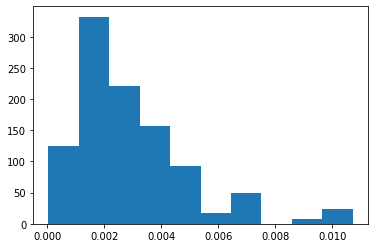

In [272]:
plt.hist(samps_probs)

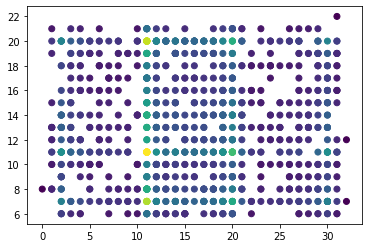

In [275]:
if disc_layer_type == 'bipartite':
    a = model.forward(samps.view(batch_size, -1)).view(batch_size, 2, -1).argmax(-1)
else:
    a = model.forward(samps).argmax(-1)
plt.scatter(a[:,0], a[:,1], c=samps_probs, cmap=plt.get_cmap('viridis'))

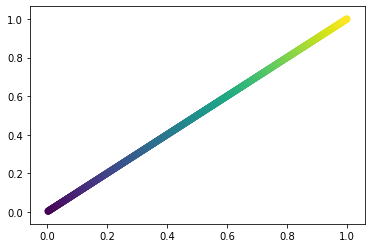

In [274]:
mu = 1/samps_probs.max().detach().numpy()
lin= np.linspace(samps_probs.min(), samps_probs.max(), batch_size)*mu
plt.scatter(lin, lin, 
            c=lin, cmap=plt.get_cmap('viridis'))

## What is the lowest loss that I should expect to see? 

In [276]:
res= []
b_size = 1000
for i in range(100):
    samps = base.sample((b_size,)).float()
    logprob = samps*base_log_probs
    res.append(-torch.sum(logprob)/b_size)
    
np.mean(np.asarray(res))

6.043825

(0, 35)

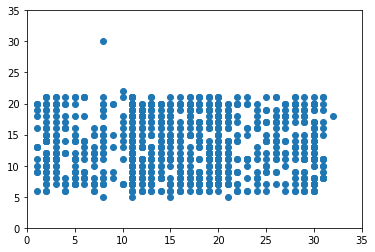

In [277]:
s = samps.argmax(-1)
plt.scatter(s[:,0], s[:,1])
plt.xlim([0,vocab_size])
plt.ylim([0,vocab_size])

Text(0.5, 1.0, 'Distribution of optimal scores')

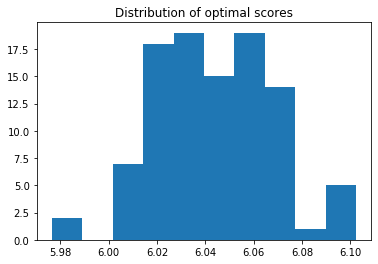

In [278]:
plt.hist(res)
plt.title('Distribution of optimal scores')

## Looking at the probability grid of the sequences

In [279]:
# what is the probability grid? 

x = np.arange(vocab_size)
xv, yv = np.meshgrid(x, x)

In [280]:
comb = np.vstack([xv.flatten(),yv.flatten()]).T
comb.shape

(1225, 2)

In [281]:
# turn into one hot and then see what the probs are. for the cateogorical. 
# then map into the data space and see. 

def onehotter(inp):
    
    x = torch.tensor(inp)
    x = x.flatten().long().unsqueeze(1)
    z = torch.zeros(inp.shape[0]*inp.shape[1], vocab_size)
    z.scatter_(1,x,1)
    z = z.view(inp.shape[0], inp.shape[1], vocab_size)
    return z

In [282]:
comb = onehotter(comb)
comb.shape

torch.Size([1225, 2, 35])

In [283]:
grid_probs = torch.exp((torch.log(base.probs) * comb).sum(-1).sum(-1))
grid_probs.shape

torch.Size([1225])

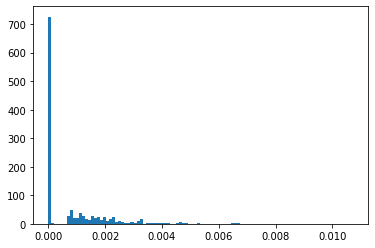

In [284]:
plt.hist(grid_probs, bins=100)
plt.show()

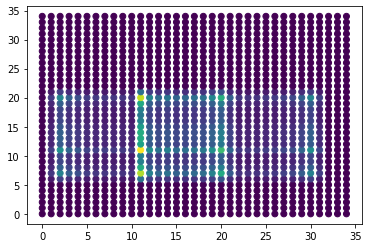

In [285]:
# this matches what the histogram outlined!
a = comb.argmax(-1)
plt.scatter(a[:,0], a[:,1], c=grid_probs, cmap=plt.get_cmap('viridis'))

(0, 35)

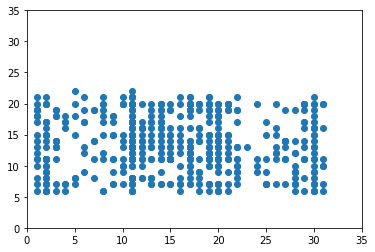

In [286]:
rand = base.sample((500,)).argmax(-1)
plt.scatter(rand[:,0], rand[:,1])
plt.xlim(0,35); plt.ylim(0,35)

In [287]:
comb.shape

torch.Size([1225, 2, 35])

In [306]:
a = model.forward(comb.view(comb.shape[0], -1)).view(comb.shape[0], 2, -1).argmax(-1)
plt.scatter(a[:,0], a[:,1], c=grid_probs, cmap=plt.get_cmap('viridis'))

IndexError: too many indices for tensor of dimension 2

In [191]:
comb.argmax(-1)[0:10,:]

tensor([[0, 0],
        [1, 0],
        [2, 0],
        [3, 0],
        [4, 0],
        [5, 0],
        [6, 0],
        [7, 0],
        [8, 0],
        [9, 0]])

In [192]:
a[:10,:]

tensor([[ 1, 32],
        [ 4, 33],
        [ 4, 34],
        [10,  0],
        [10,  1],
        [10,  2],
        [ 8,  3],
        [ 8,  4],
        [10,  5],
        [ 8,  6]])

## Looking at the highest prob regions

In [193]:
comb_high_probs = comb[grid_probs>0.004]
high_probs = grid_probs[grid_probs>0.004]
comb_high_probs.shape

torch.Size([41, 2, 35])

(0, 35)

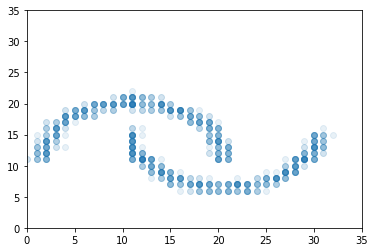

In [194]:
x = int_moons_sample(batch_size)
plt.scatter(x.argmax(-1)[:,0],x.argmax(-1)[:,1], alpha=0.1 )
plt.xlim(0,35); plt.ylim(0,35)

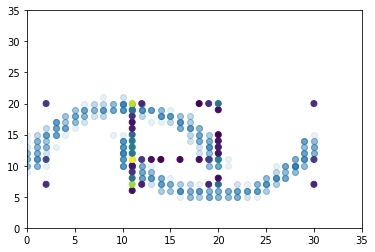

In [195]:
x = int_moons_sample(batch_size)
plt.scatter(x.argmax(-1)[:,0],x.argmax(-1)[:,1], alpha=0.1 )
plt.xlim(0,35); plt.ylim(0,35)
a = comb_high_probs.argmax(-1)
plt.scatter(a[:,0], a[:,1], c=high_probs, cmap=plt.get_cmap('viridis'))

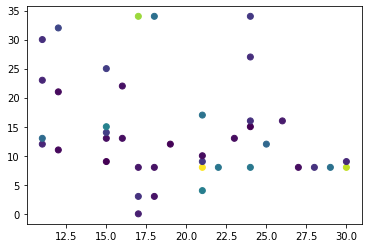

In [198]:
a = model.forward(comb_high_probs.view(comb_high_probs.shape[0], -1)).view(comb_high_probs.shape[0],2, -1).argmax(-1)
plt.scatter(a[:,0], a[:,1], c=high_probs, cmap=plt.get_cmap('viridis'))

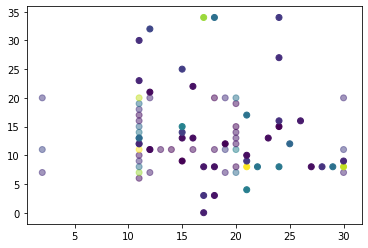

In [199]:
b=comb_high_probs.argmax(-1)
plt.scatter(b[:,0], b[:,1], c=high_probs, cmap=plt.get_cmap('viridis'),alpha=0.5)
plt.scatter(a[:,0], a[:,1], c=high_probs, cmap=plt.get_cmap('viridis'))

In [713]:
comb_high_probs.argmax(-1)[0:10,:]

tensor([[ 2,  7],
        [11,  7],
        [12,  7],
        [19,  7],
        [20,  7],
        [30,  7],
        [11,  8],
        [20,  8],
        [11,  9],
        [11, 10]])

In [714]:
a[:10,:]

tensor([[ 0,  5],
        [ 9,  5],
        [10,  5],
        [17,  5],
        [18,  5],
        [28,  5],
        [ 9,  6],
        [18,  6],
        [ 9,  7],
        [ 9,  8]])

In [671]:
comb_high_probs.shape

torch.Size([40, 2, 35])

In [672]:
# seeing what the highest possible scores can be. 



logprob = comb_high_probs*base_log_probs
-torch.sum(logprob)/comb_high_probs.shape[0]
    


tensor(5.2563)

# Scraps in making a one hot adder


In [364]:
inputs = torch.tensor(oh[:64,:,:]).float()
loc = layer(inputs)
loc = disc_utils.one_hot_argmax(loc, 0.1).type(inputs.dtype)
print(loc.shape)
disc_utils.one_hot_add(loc, inputs).shape

torch.Size([64, 2, 150])


torch.Size([64, 2, 151])

In [70]:
t_res_sub = disc_utils.one_hot_minus( inputs, loc )

In [34]:
torch.rfft(loc,3).shape

torch.Size([64, 2, 76, 2])

In [35]:
torch.rfft(inputs,3).shape

torch.Size([64, 2, 76, 2])

In [36]:
torch.irfft(torch.rfft(loc,3) * torch.rfft(inputs,3),3)

tensor([[[0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818],
         [0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818]],

        [[0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818],
         [0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818]],

        [[0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818],
         [0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818]],

        ...,

        [[0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818],
         [0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818]],

        [[0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818],
         [0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818]],

        [[0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818],
         [0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818]]],
       grad_fn=<SqueezeBackward1>)

In [37]:
torch.irfft(torch.rfft(loc,3) * torch.rfft(inputs,3),3).shape

torch.Size([64, 2, 151])

In [247]:
inp = torch.tensor([1,2,3,4,5]).float()-1
inp_oh = torch.zeros((5,5))
inp_oh = inp_oh.scatter_(1, inp.unsqueeze(1).long(), 1)

In [248]:
inp_oh.shape

torch.Size([5, 5])

In [298]:
shifter = disc_utils.one_hot_argmax(torch.rand((5,1,5)), 0.1)
#torch.softmax(torch.rand((5)), -1)
shifter

tensor([[[0., 0., 1., 0., 0.]],

        [[0., 1., 0., 0., 0.]],

        [[0., 0., 0., 1., 0.]],

        [[0., 0., 1., 0., 0.]],

        [[1., 0., 0., 0., 0.]]])

In [299]:
torch.sum(torch.arange(5)*shifter)

tensor(8.)

In [300]:
shifter.shape

torch.Size([5, 1, 5])

In [348]:
shifter[0,0,:]

tensor([0., 0., 1., 0., 0.])

In [349]:
inp_oh[1,:] #0-3=-3%5 = 2
# 1-3=-2%5=3
# 1+3 = 4 % 5 = 1


# 1 - 2 = -1 %5  = 4
# 1+2 = 3%5 = 3

tensor([0., 1., 0., 0., 0.])

In [350]:
torch.einsum('...v,...uv->...u', inp_oh[1,:].float(), shift_mat[0,0,:,:].float())

tensor([0., 0., 0., 0., 1.])

In [351]:
shift_mat = torch.stack( 
    [torch.roll(shifter, i, dims=-1) for i in (range(5))],
    dim=-2).float()
shift_mat.shape


torch.Size([5, 1, 5, 5])

In [352]:
shift_mat[0,0,:,:]

tensor([[0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.]])

In [342]:
shift_mat[0,0,:,:]

tensor([[0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.]])

In [343]:
inp_oh.shape

torch.Size([5, 5])

In [344]:
shift_mat.shape

torch.Size([5, 1, 5, 5])

In [354]:
shifter[:,0,:]

tensor([[0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.]])

In [353]:
inp_oh

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])

In [362]:
shift_mat[0,0,:,:]

tensor([[0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.]])

In [359]:
shift_mat[0,0,:,:].T

tensor([[0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.]])

In [360]:
shift_mat_T = torch.transpose(shift_mat,-1,-2)

In [361]:
torch.einsum('...v,...uv->...u', inp_oh.unsqueeze(1).float(), shift_mat_T.float())

tensor([[[0., 0., 1., 0., 0.]],

        [[0., 0., 1., 0., 0.]],

        [[1., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1.]]])

In [86]:
inputs.shape

TensorShape([64, 2, 150])

In [87]:
loc.shape

TensorShape([64, 2, 150])

In [273]:
import tensorflow as tf
import edward2 as ed2
loc = tf.constant(loc.detach().numpy())
inputs = tf.constant(inputs.detach().numpy())

In [371]:
import disc_utils

In [372]:
tor_add = disc_utils.one_hot_add_simple(inputs, loc)

/Users/trentonbricken/protein-gen/notebooks/disc_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale = scale.type( inputs.dtype)


In [376]:
tor_add.shape

torch.Size([64, 2, 150])

In [375]:
j=4
print( tor_add[j,0,:].argmax(), loc[j,0,:].argmax(), inputs[j,0,:].argmax())

tensor(101) tensor(20) tensor(81)


In [283]:

res_add = ed2.tensorflow.layers.utils.one_hot_add(loc,inputs)
res_add[0,0,:].numpy().argmax()

91

In [284]:
loc[0,0,:].numpy().argmax()

20

In [285]:
inputs[0,0,:].numpy().argmax()

71

In [79]:
def one_hot_simp_add(inputs, shift):
  """Performs (inputs - shift) % vocab_size in the one-hot space.
  Args:
    inputs: Tensor of shape `[..., vocab_size]`. Typically a soft/hard one-hot
      Tensor.
    shift: Tensor of shape `[..., vocab_size]`. Typically a soft/hard one-hot
      Tensor specifying how much to shift the corresponding one-hot vector in
      inputs. Soft values perform a "weighted shift": for example,
      shift=[0.2, 0.3, 0.5] performs a linear combination of 0.2 * shifting by
      zero; 0.3 * shifting by one; and 0.5 * shifting by two.
  Returns:
    Tensor of same shape and dtype as inputs.
  """
  # TODO(trandustin): Implement with circular conv1d.
  inputs = tf.convert_to_tensor(inputs)
  shift = tf.cast(shift, inputs.dtype)
  vocab_size = inputs.shape[-1]
  
  # Form a [..., vocab_size, vocab_size] matrix. Each batch element of
  # inputs will vector-matrix multiply the vocab_size x vocab_size matrix. This
  # "shifts" the inputs batch element by the corresponding shift batch element.
  shift_matrix = tf.stack([tf.roll(shift, i, axis=-1)
                           for i in range(vocab_size)], axis=-2)
  outputs = tf.einsum('...v,...uv->...u', inputs, shift_matrix)
  return outputs

In [83]:
res_add_simple = one_hot_simp_add(inputs, -loc)


In [175]:
res_add

<tf.Tensor: id=966, shape=(64, 2, 150), dtype=float32, numpy=
array([[[-1.39077505e-08,  6.16050926e-08,  8.06805431e-08, ...,
          2.07518425e-09,  1.41010847e-08,  2.90336484e-08],
        [-4.53988704e-08, -1.05245928e-08, -3.14599333e-08, ...,
          2.92471771e-08, -4.65775791e-08,  8.32149425e-08]],

       [[-3.41733291e-08, -4.92956538e-08,  9.18260312e-08, ...,
         -6.81949146e-08,  3.31483285e-08, -1.94591241e-08],
        [ 3.76701365e-07,  2.26353151e-07,  1.23996514e-07, ...,
         -5.16586134e-08,  9.79530590e-09, -7.09407971e-07]],

       [[-1.29540766e-07,  3.38414630e-08, -3.11788995e-08, ...,
         -4.34769838e-08, -6.02295458e-09, -4.69469548e-08],
        [ 1.04904174e-07,  2.37671586e-07, -9.71124194e-08, ...,
         -5.45487637e-08, -5.72065382e-08,  1.21280365e-07]],

       ...,

       [[ 5.99026677e-08, -6.21348306e-08, -2.20887088e-07, ...,
          7.00678342e-08,  2.92297159e-07, -6.02593445e-07],
        [-1.31527585e-07,  2.42835814

In [84]:
res_add_simple[0,0,:5]

<tf.Tensor: id=2362, shape=(5,), dtype=float32, numpy=array([0., 0., 0., 0., 0.], dtype=float32)>

In [85]:
res_add == res_add_simple

<tf.Tensor: id=2363, shape=(64, 2, 150), dtype=bool, numpy=
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       ...,

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])>

In [64]:
res_sub = ed2.tensorflow.layers.utils.one_hot_minus(inputs, loc )

In [65]:
res_add[0,0,:5]

<tf.Tensor: id=1428, shape=(5,), dtype=float32, numpy=
array([-1.39077505e-08,  6.16050926e-08,  8.06805431e-08, -8.64888676e-08,
        1.04205597e-07], dtype=float32)>

In [73]:
res_sub.numpy() == t_res_sub.detach().numpy()

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       ...,

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]])